In [1]:
# =============================================================================
# Created By:     Kai Metzger
# Created School: Franz-Oberthuer-Schule Wuerzburg
# Created Email:  metzgerkai@franz-oberthuer-schule.de
# Created Date:   Mon Dec 01 17:25 UTC 2025
# Version:        1.0.0
# =============================================================================
"""The Module has been build for training the symbols dataset with images + 
ground truth. Images have the base dimenstions of 640px x 480px in datasets 1-8
and then another 700 images with resolution 1920px x 1080px have been added to  
the subsequent datasets.
The files in the dataset <symbols> should be ordered in the following
manner:             > explanation
- symbols      
  - # dataset e.g. datset10 the corresponding classes are stored in folders 0-3:
    #     classA/     = cross       351
    #     classB/     = circle      348
    #     classC/     = triangle    350
    #     classD/     = rectangle   351
"""

# =============================================================================
# Import
# =============================================================================
import cv2
import os
import numpy as np
from keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.optimizers.schedules import ExponentialDecay

# Enable Nvidia GPUs by un-commenting this line 
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
XLA_FLAGS="--xla_gpu_cuda_data_dir=/usr/"

SEED = 42

2025-12-03 11:07:41.052469: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# =============================================================================
# Declare variables
# =============================================================================
# Change the following paths to your dataset path
home_dir = os.path.expanduser("~/git")
dataset_for_training = home_dir + "/ml_project/datasets/symbols/dataset10"

print("Dataset:", dataset_for_training)

Dataset: /home/kai/git/ml_project/datasets/symbols/dataset10


In [3]:
# =============================================================================
# Dataset related
# =============================================================================
NUM_CLASSES = 4
IMG_SIZE_X = 160
IMG_SIZE_Y = 160
IMG_SIZE = (IMG_SIZE_X, IMG_SIZE_Y)

INPUT_SHAPE = (IMG_SIZE_X, IMG_SIZE_Y, 3) # color
#INPUT_SHAPE = (IMG_SIZE_X, IMG_SIZE_Y, 1) # grayscale

# =============================================================================
# Hyperparameters
# =============================================================================
BATCH_SIZE = 32
EPOCHS = 300
BASE_LEARNING_RATE = 1e-4 #0.0001

# Set up an exponential decay learning rate schedule
LR_SCHEDULER = ExponentialDecay(
    initial_learning_rate=BASE_LEARNING_RATE,  # start with 0.001
    decay_steps=100000,           # how often to apply the decay
    decay_rate=0.96,              # decay rate
    staircase=True                # whether to apply the decay in steps
)

OPTIMIZER = keras.optimizers.Adam(learning_rate=LR_SCHEDULER)

I0000 00:00:1764756464.249746   37433 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4617 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_for_training,
    labels="inferred",
    label_mode="categorical",           # 4 Klassen → 1-hot
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_for_training,
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 1400 files belonging to 4 classes.
Using 1120 files for training.
Found 1400 files belonging to 4 classes.
Using 280 files for validation.


In [5]:
class_names = train_dataset.class_names
NUM_CLASSES = len(class_names)
print("Klassen:", class_names, "\n")

Klassen: ['0', '1', '2', '3'] 



2025-12-03 11:07:45.702970: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


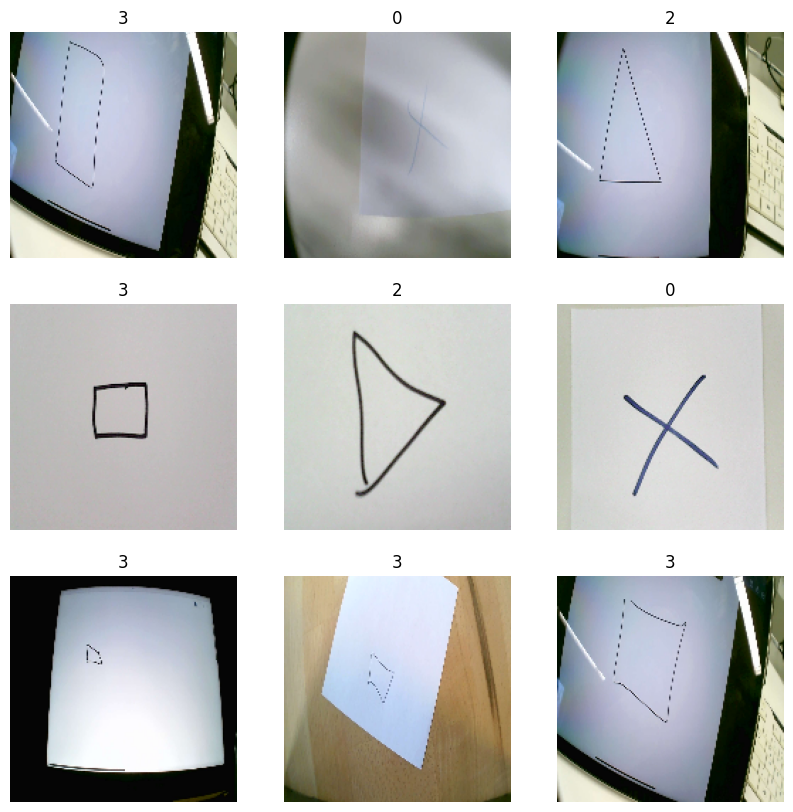

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = labels[i].numpy().argmax()
        plt.title(class_names[label_index])
        plt.axis("off")


In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
#test_dataset = validation_dataset.take(val_batches // 5)
#validation_dataset = validation_dataset.skip(val_batches // 5)
test_dataset = validation_dataset.take(val_batches // 4)
validation_dataset = validation_dataset.skip(val_batches // 4)

In [8]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of training batches: 35
Number of validation batches: 7


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print('Number of testing batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of testing batches: 2


In [10]:
# =============================================================================
# Data Augmentation
# =============================================================================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.2),   
])

# =============================================================================
# Full Data Augmentation Pipeline
# =============================================================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),             # flip left/right
    layers.RandomRotation(0.1),                  # rotate ±10%
    layers.RandomZoom(0.1),                      # zoom in/out
    layers.RandomTranslation(0.1, 0.1),          # shift X/Y
    layers.RandomBrightness(factor=0.1),         # color jitter (TF 2.15+)
    layers.RandomContrast(0.1),                  # adjust contrast
    layers.RandomGaussianBlur(
        kernel_size=3,     # size of blur kernel (3, 5, etc.)
        sigma=(0.1, 2.0)   # range of possible blur intensity
    )  
])

2025-12-03 11:07:49.964083: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


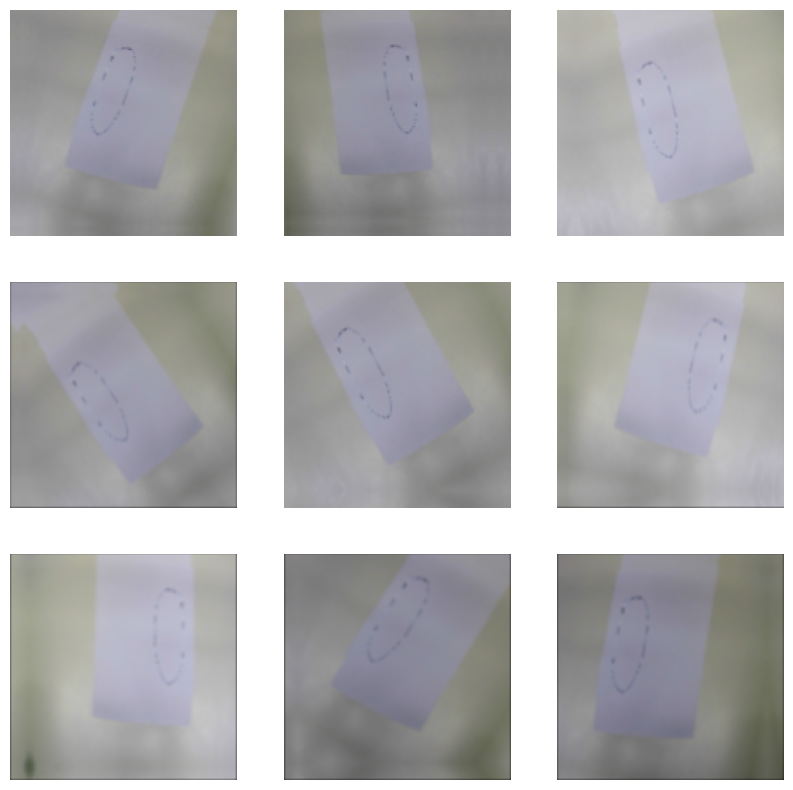

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [12]:
# AUTOTUNE
# =============================================================================
# TensorBoard Logging
# =============================================================================
log_dir = "logs/fit"
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

# Starten in Shell: tensorboard --logdir logs/fit

In [ ]:
# =============================================================================
# MobileNetV2 (Transfer Learning)
# =============================================================================
base_model = tf.keras.applications.MobileNetV2(
#base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers
inputs = keras.Input(shape=IMG_SIZE + (3,))

x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
#x = tf.keras.applications.mobilenet_v3.preprocess_input(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# =============================================================================
# Training (Feature Extraction)
# =============================================================================
initial_epochs = 25

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs,
    shuffle=True,
    callbacks=[tensorboard_callback],
)

# Starten in Shell: tensorboard --logdir logs/fit

Epoch 1/25


2025-12-03 11:07:56.533186: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91501


35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.2911 - loss: 1.7262 - val_accuracy: 0.2639 - val_loss: 1.6266
Epoch 2/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.3429 - loss: 1.4538 - val_accuracy: 0.3472 - val_loss: 1.4351
Epoch 3/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.4313 - loss: 1.2796 - val_accuracy: 0.4306 - val_loss: 1.2593
Epoch 4/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.5170 - loss: 1.1428 - val_accuracy: 0.5139 - val_loss: 1.1519
Epoch 5/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.5839 - loss: 1.0179 - val_accuracy: 0.5694 - val_loss: 1.0364
Epoch 6/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.6054 - loss: 0.9600 - val_accuracy: 0.6019 - val_loss: 0.9554
Epoch 7/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.6250 - loss: 0.8982 - val_accuracy: 0.6250 - val_loss: 0.8891
Epoch 8/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.6687 - loss: 0.8480 - val_accuracy: 0.6343 - val

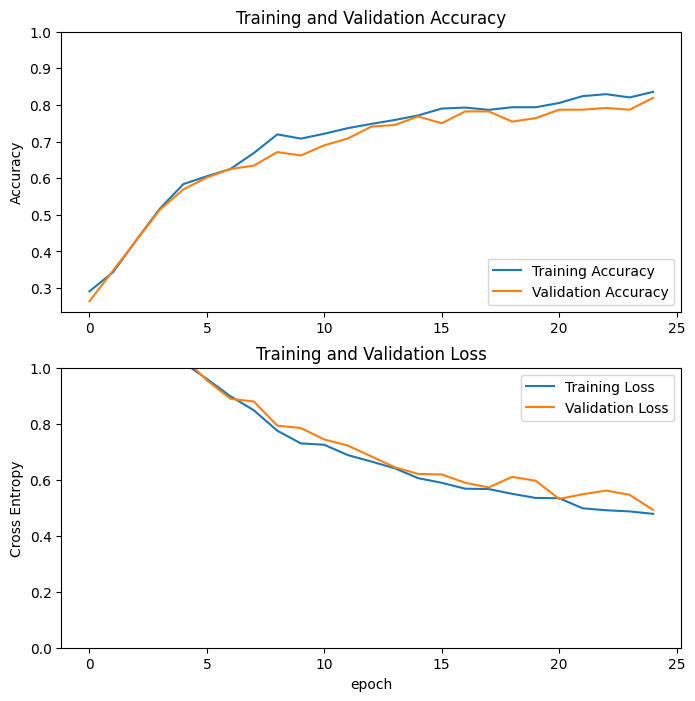

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
# =============================================================================
# Fine Tuning
# =============================================================================
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_from = 100

for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=BASE_LEARNING_RATE/10), # = 1e-5
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_epochs = 75
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    shuffle=True,
    callbacks=[tensorboard_callback],
)

Number of layers in the base model:  154
Epoch 26/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 186ms/step - accuracy: 0.6982 - loss: 0.7943 - val_accuracy: 0.8380 - val_loss: 0.4087
Epoch 27/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.7402 - loss: 0.6514 - val_accuracy: 0.8519 - val_loss: 0.3933
Epoch 28/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.7848 - loss: 0.5636 - val_accuracy: 0.8194 - val_loss: 0.4225
Epoch 29/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.8214 - loss: 0.4796 - val_accuracy: 0.8565 - val_loss: 0.3722
Epoch 30/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.8321 - loss: 0.4469 - val_accuracy: 0.8704 - val_loss: 0.3462
Epoch 31/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.8330 - loss: 0.4165 - val_accuracy: 0.8704 - val_loss: 0.3450
Epoch 32/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.8696 - loss: 0.3772 - val_accuracy: 0.8704 - val_loss: 0.3352
Epoch 33/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

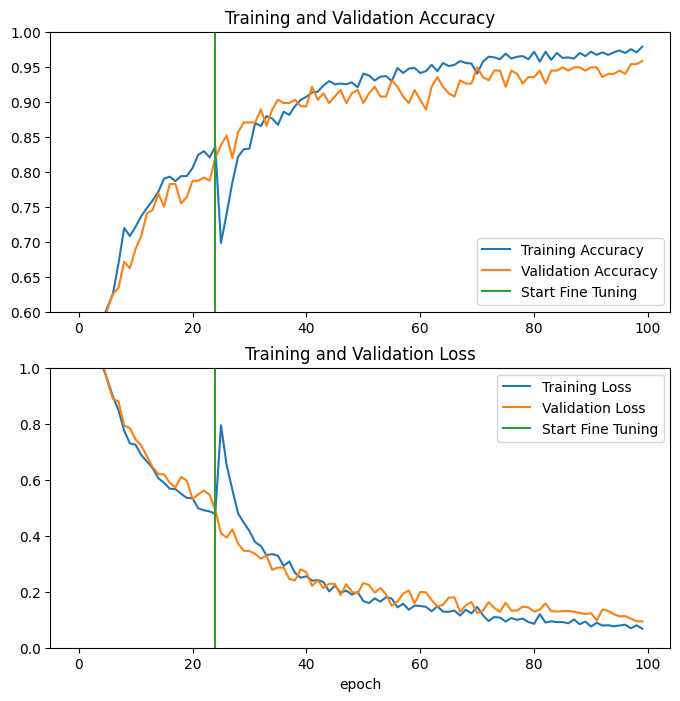

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
# =============================================================================
# Test Accuracy (Validation = Test)
# =============================================================================
loss, acc = model.evaluate(validation_dataset)
#TODO loss, accuracy = model.evaluate(test_dataset)

print("Test Accuracy:", acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9444 - loss: 0.1213
Test Accuracy: 0.9444444179534912


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
Klassen: ['0', '1', '2', '3']


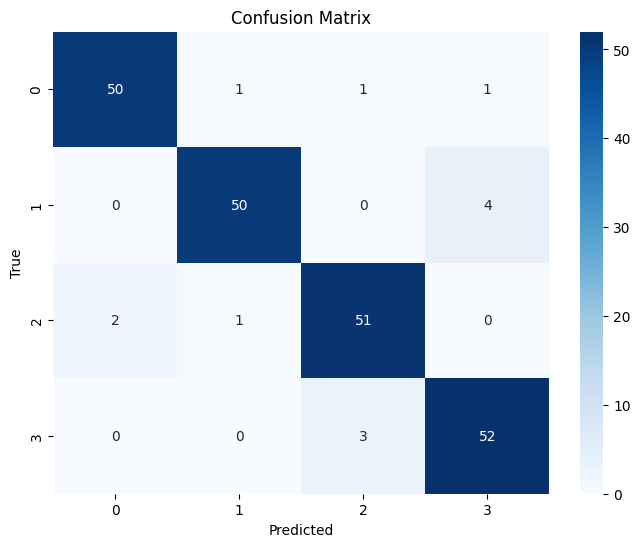


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        53
           1       0.96      0.93      0.94        54
           2       0.93      0.94      0.94        54
           3       0.91      0.95      0.93        55

    accuracy                           0.94       216
   macro avg       0.94      0.94      0.94       216
weighted avg       0.94      0.94      0.94       216



In [21]:
# =============================================================================
# Konfusionsmatrix + Klassifizierungsreport
# =============================================================================
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Daten aus Validation/Test holen
y_true = []
y_pred = []

for images, labels in validation_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Klassenliste
print("Klassen:", class_names)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [22]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9375 - loss: 0.1455
Test accuracy : 0.9375


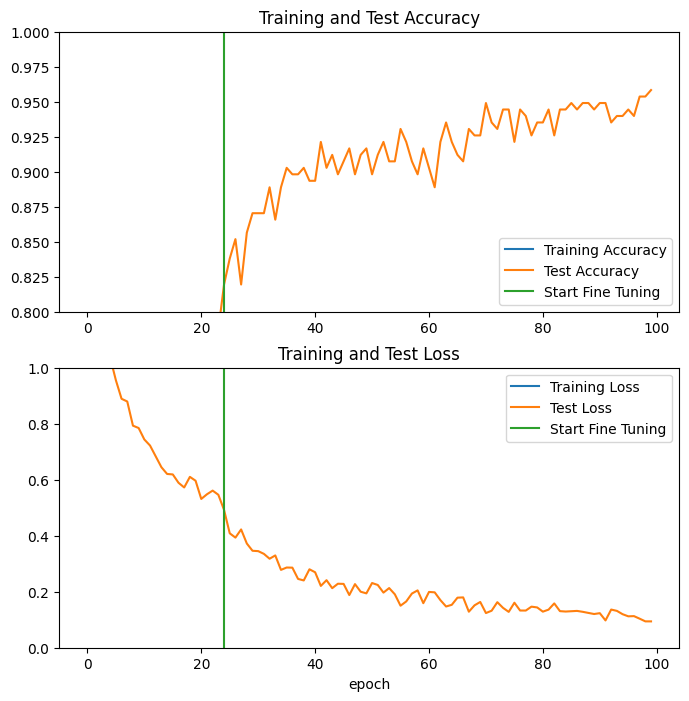

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Test Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Test Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.xlabel('epoch')
plt.show()

Last conv layer: Conv_1
tf.Tensor([[7.9979934e-04 2.4945664e-05 9.9874157e-01 4.3372574e-04]], shape=(1, 4), dtype=float32)


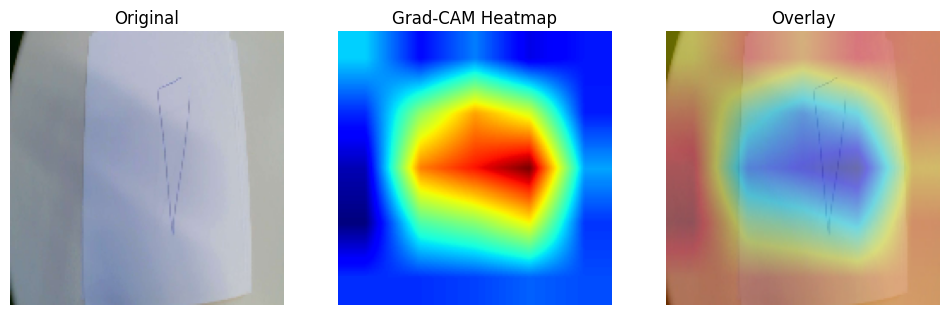

Predicted class: 2


In [28]:
# =============================================================================
# Grad-CAM Visualisierung
# =============================================================================

# ============================================================
# 1. Extract MobileNetV2 backbone
# ============================================================
backbone = model.get_layer("mobilenetv2_1.00_160")

# Find last conv layer inside MobileNetV2
last_conv = None
for layer in reversed(backbone.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv = layer
        break

print("Last conv layer:", last_conv.name)


# ============================================================
# 2. Create a Grad-CAM model for MobileNetV2 only
# ============================================================
grad_model = tf.keras.models.Model(
    inputs=backbone.input,            # internal input of MobileNetV2
    outputs=[last_conv.output,        # feature map
             backbone.output]         # MobileNetV2 embeddings
)


# ============================================================
# 3. Extract and preprocess image manually (bypass Sequential)
# ============================================================
example_img, _ = next(iter(validation_dataset))
example_img = example_img[0].numpy() # shape: (H,W,3)

# Your model expects raw 0–255
if example_img.max() <= 1.0:
    example_img = example_img * 255.

# Apply SAME preprocessing as your Sequential layer
# Apply Rescaling(1./127.5, offset=-1) manually
img_pp = (example_img / 127.5) - 1

# final MobileNetV2 input
input_backbone = np.expand_dims(img_pp, 0)


# ============================================================
# 4. Run Grad-CAM on the backbone
# ============================================================
with tf.GradientTape() as tape:
    conv_outputs, features = grad_model(input_backbone)
    conv_outputs = conv_outputs[0]

# use full model for final class prediction
full_pred = model(np.expand_dims(example_img, 0))
pred_index = tf.argmax(full_pred[0]).numpy()
print(full_pred)

# MobileNetV2 embeddings → Dense layer → final class  
dense_weights = model.layers[-1].get_weights()[0]     # (1280, num_classes)
weights_for_class = dense_weights[:, pred_index]       # shape (1280,)

# Compute Grad-CAM manually from MobileNetV2 embeddings
grads = weights_for_class
heatmap = tf.reduce_sum(tf.multiply(conv_outputs, grads), axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= heatmap.max() + 1e-8


# ============================================================
# 5. Visualization
# ============================================================
img_uint8 = example_img.astype("uint8")

heatmap_resized = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

overlay = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)


plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img_uint8)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap_resized, cmap='jet')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()

print("Predicted class:", class_names[pred_index])


In [25]:
# =============================================================================
# Modell speichern
# =============================================================================
keras.saving.save_model(model, "model.keras")

print("Modelle gespeichert: model.keras")

# =============================================================================
# Modell laden
# =============================================================================
loaded_model = keras.models.load_model("model.keras")

print("Modelle erfolgreich geladen!")

Modelle gespeichert: model.keras
Modelle erfolgreich geladen!
